## Analyze noise non-iid


In [182]:
import numpy as np
import matplotlib.pyplot as plt
from lib.generate_timeseries import Periodic_1d
import torch
from collections import Counter
from matplotlib import cm
from torch.distributions import uniform
import pandas as pd
import seaborn as sns
import sys
import json
import glob
import os
os.chdir("/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin")
sys.path.append(os.getcwd()) 
sns.set(style='whitegrid')
from lib.dataset_utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
from plot_utils import read_loss_file
from flower.task import Net
from plot_utils import plot_n_outputs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
def prepare_df_for_plotting(result_json, convergence_range=1.1):
    df_summary_centralized = pd.DataFrame()
    df_summary_federated = pd.DataFrame()
    df_summary_aggregation = pd.DataFrame()
    for file in result_json:
        noise = float(file.split("noise_")[-1].split("_")[0].split("/")[0])
        df_centralized_evaluate, df_federated_evaluate, df_aggregation = read_loss_file(file)
        df_centralized_evaluate['noise'] = noise
        df_summary_centralized = pd.concat([df_summary_centralized, df_centralized_evaluate], ignore_index=True)
        df_federated_evaluate['noise'] = noise
        df_summary_federated = pd.concat([df_summary_federated, df_federated_evaluate], ignore_index=True)
        df_aggregation['noise'] = noise
        df_summary_aggregation = pd.concat([df_summary_aggregation, df_aggregation], ignore_index=True)

    # find the min loss for each noise, aggreagation, type 
    df_summary_centralized['min_loss'] = df_summary_centralized.groupby(['noise', 'aggregation', 'type'])['loss'].transform('min')

    # per noise, aggregation, type get the convergence_round, which is the min round where the loss is within 1/10 of the min loss
    df_summary_centralized['convergence_round'] = df_summary_centralized.groupby(['noise', 'aggregation', 'type'])['round'].transform(
        lambda x: x[df_summary_centralized['loss'] <= df_summary_centralized['min_loss'] * convergence_range].min()
    )

    df_summary_federated['min_loss'] = df_summary_federated.groupby(['noise', 'aggregation', 'type'])['loss'].transform('min')
    df_summary_federated['convergence_round'] = df_summary_federated.groupby(['noise', 'aggregation', 'type'])['round'].transform(
        lambda x: x[df_summary_federated['loss'] <= df_summary_federated['min_loss'] * convergence_range].min()
    )

    df_summary_federated = df_summary_federated[['round', 'loss', 'aggregation', 'type', 'alpha', 'noise', 'min_loss', 'convergence_round']]
    df_summary_centralized = df_summary_centralized[['round', 'loss', 'aggregation', 'type', 'alpha', 'noise', 'min_loss', 'convergence_round']]
    df_summary = pd.concat([df_summary_federated, df_summary_centralized], ignore_index=True)
    df_summary = df_summary[['aggregation', 'type', 'alpha', 'noise', 'min_loss', 'convergence_round']]
    df_summary = df_summary.drop_duplicates()

    return df_summary

## Noise unilateral

In [136]:
result_json_one = glob.glob(f"../results_freq_noise/*noise_one*/federated_training/**/100_rounds/**/results.json", recursive=True)
print(f"Found {len(result_json_one)} files for noise one")
df_summary_one = prepare_df_for_plotting(result_json_one)

Found 67 files for noise one


In [128]:
df_summary_one_federated = df_summary_one[df_summary_one['type'] == 'federated']

In [172]:
result_json_both = glob.glob(f"../results_freq_noise/*noise_both*/federated_training/**/100_rounds/**/results.json", recursive=True)
print(f"Found {len(result_json_both)} files for noise both")
df_summary_both = prepare_df_for_plotting(result_json_both)

Found 64 files for noise both


In [173]:
df_summary_both_federated = df_summary_both[df_summary_both['type'] == 'federated']

<Figure size 1000x300 with 0 Axes>

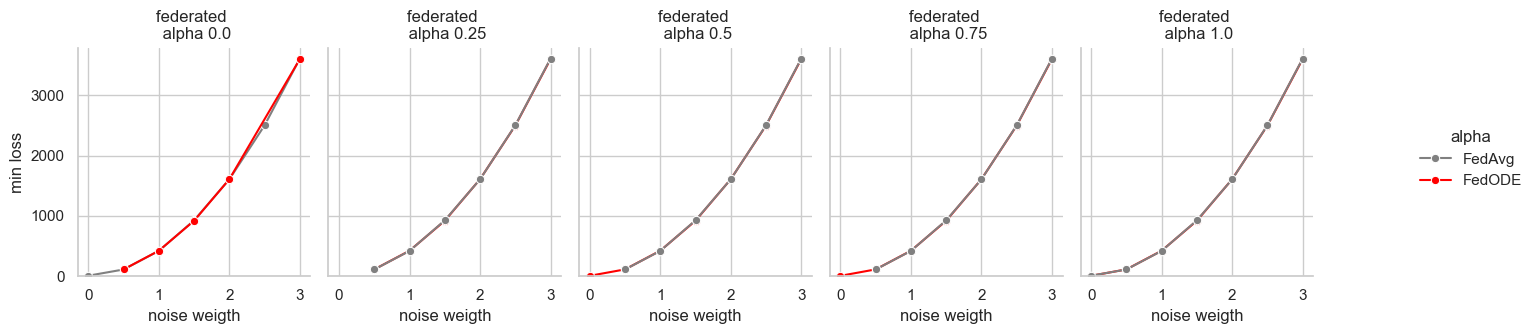

In [175]:
######################################
#  Plot the last loss vs difference
######################################
plt.figure(figsize=(10, 3))
# Create FacetGrid
g = sns.FacetGrid(
    df_summary_both_federated,
    col="alpha",
    row="type",
    height=3.5,
    aspect=0.7,  # Width = height * aspect
    sharey=True
)


# make palette red and grey 
palette_red_grey = {
    'FedODE': 'red',
    'FedAvg': 'grey'
}

# Map the lineplot onto the grid
g.map_dataframe(
    sns.lineplot,
    x='noise',
    y='min_loss',
    hue='aggregation',
    palette=palette_red_grey,
    marker='o'
)

# Adjustments
g.set_titles("{row_name} \n alpha {col_name}")
g.set(ylim=(0, None))
# set x axis
g.set(xlabel='noise weigth', ylabel='min loss')
# Move legend outside
g.add_legend(title ="alpha")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
plt.tight_layout()
plt.show()


In [141]:
df_summary_centralized = pd.DataFrame()
df_summary_federated = pd.DataFrame()
df_summary_aggregation = pd.DataFrame()
for file in result_json_one:
    noise = float(file.split("noise_")[-1].split("_")[0].split("/")[0])
    df_centralized_evaluate, df_federated_evaluate, df_aggregation = read_loss_file(file)
    df_centralized_evaluate['noise'] = noise
    df_summary_centralized = pd.concat([df_summary_centralized, df_centralized_evaluate], ignore_index=True)
    df_federated_evaluate['noise'] = noise
    df_summary_federated = pd.concat([df_summary_federated, df_federated_evaluate], ignore_index=True)
    df_aggregation['noise'] = noise
    df_summary_aggregation = pd.concat([df_summary_aggregation, df_aggregation], ignore_index=True)

# find the min loss for each noise, aggreagation, type 
df_summary_centralized['min_loss'] = df_summary_centralized.groupby(['noise', 'aggregation', 'type'])['loss'].transform('min')

# per noise, aggregation, type get the convergence_round, which is the min round where the loss is within 1/10 of the min loss
df_summary_centralized['convergence_round'] = df_summary_centralized.groupby(['noise', 'aggregation', 'type'])['round'].transform(
    lambda x: x[df_summary_centralized['loss'] <= df_summary_centralized['min_loss'] * convergence_range].min()
)

df_summary_federated['min_loss'] = df_summary_federated.groupby(['noise', 'aggregation', 'type'])['loss'].transform('min')
df_summary_federated['convergence_round'] = df_summary_federated.groupby(['noise', 'aggregation', 'type'])['round'].transform(
    lambda x: x[df_summary_federated['loss'] <= df_summary_federated['min_loss'] * convergence_range].min()
)

df_summary_federated = df_summary_federated[['round', 'loss', 'aggregation', 'type', 'alpha', 'noise', 'min_loss', 'convergence_round']]
df_summary_centralized = df_summary_centralized[['round', 'loss', 'aggregation', 'type', 'alpha', 'noise', 'min_loss', 'convergence_round']]
df_summary = pd.concat([df_summary_federated, df_summary_centralized], ignore_index=True)

In [142]:
# extarct n_steps_list[0] into c0_steps and n_steps_list[1] into c1_steps
df_summary_aggregation["steps_0"] = df_summary_aggregation['num_steps_list'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
df_summary_aggregation["steps_1"] = df_summary_aggregation['num_steps_list'].apply(lambda x: x[1] if isinstance(x, list) and len(x) > 1 else None)
# remove nan 
df_summary_aggregation = df_summary_aggregation.dropna(subset=['steps_0', 'steps_1'])
# do same thing for lambda
df_summary_aggregation["lambda_0"] = df_summary_aggregation['lambdas'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
df_summary_aggregation["lambda_1"] = df_summary_aggregation['lambdas'].apply(lambda x: x[1] if isinstance(x, list) and len(x) > 1 else None)
df_agg = df_summary_aggregation[["round", "steps_0", "steps_1", "lambda_0", "lambda_1", "noise", "alpha"]]

df0 = df_agg[['round', 'noise', 'lambda_0', 'steps_0',  'alpha']].copy()
df0['client'] = 0
df0 = df0.rename(columns={'lambda_0': 'lambda', 'steps_0': 'steps'})
df1 = df_agg[['round', 'noise', 'lambda_1', 'steps_1',  'alpha']].copy()
df1.rename(columns={'lambda_1': 'lambda', 'steps_1': "steps"}, inplace=True)
df1['client'] = 1
df_summary_lambdas = pd.concat([df0, df1], ignore_index=True)

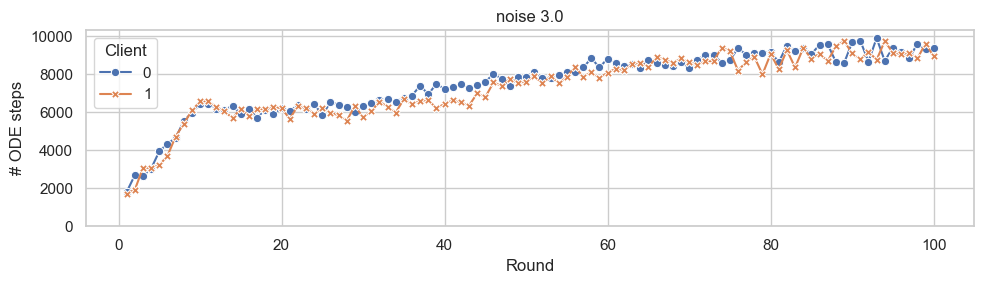

In [170]:
noise = 3.0
alpha = 0.0
df_test = df_summary_lambdas[(df_summary_lambdas['noise'] == noise) & (df_summary_lambdas['alpha'] == alpha)]
plt.figure(figsize=(10, 3))
sns.lineplot(data=df_test, x='round', y='steps', hue='client', style='client', markers=True, dashes=False)
plt.title(f"noise {noise}")
plt.xlabel("Round")
plt.ylabel("# ODE steps")
plt.legend(title='Client')
# yaxis from 0
plt.ylim(0, None)
plt.tight_layout()
plt.show()

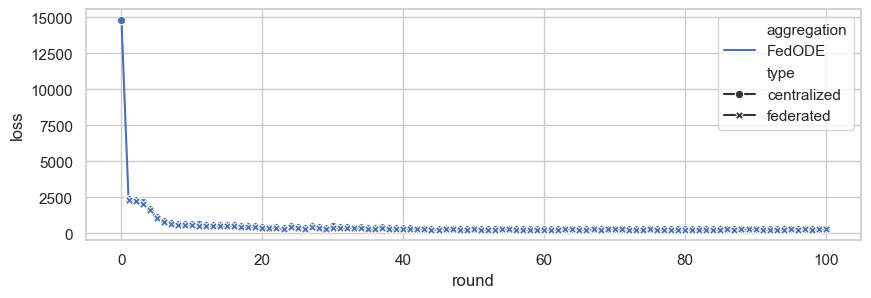

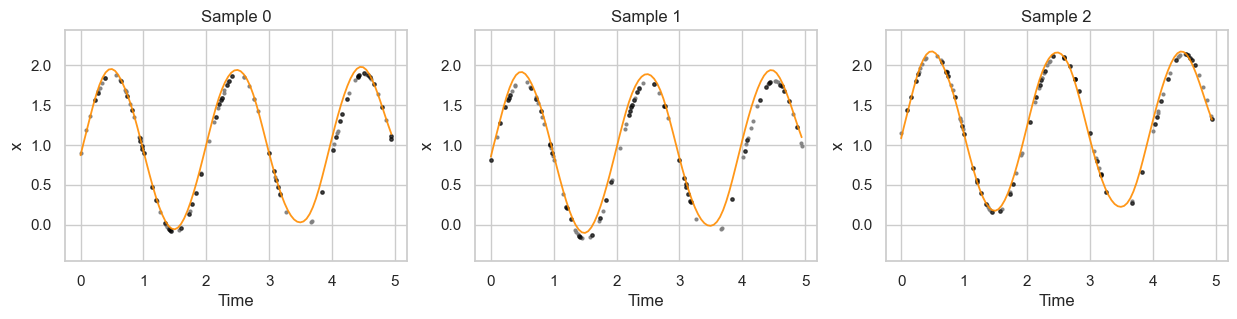

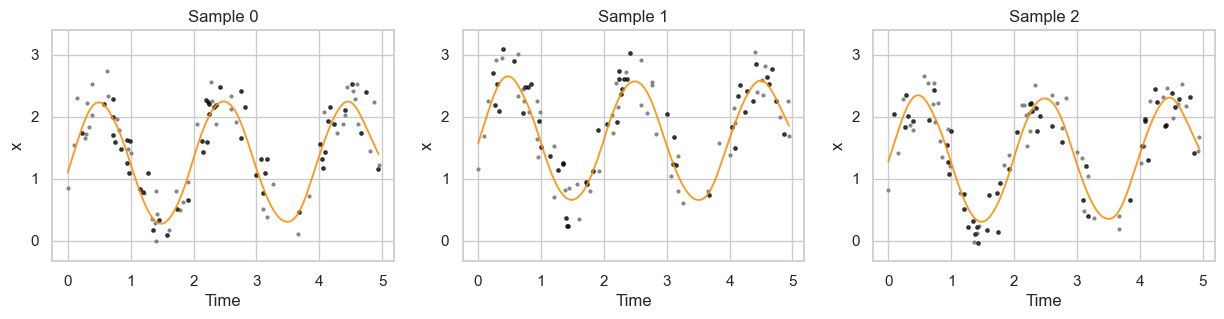

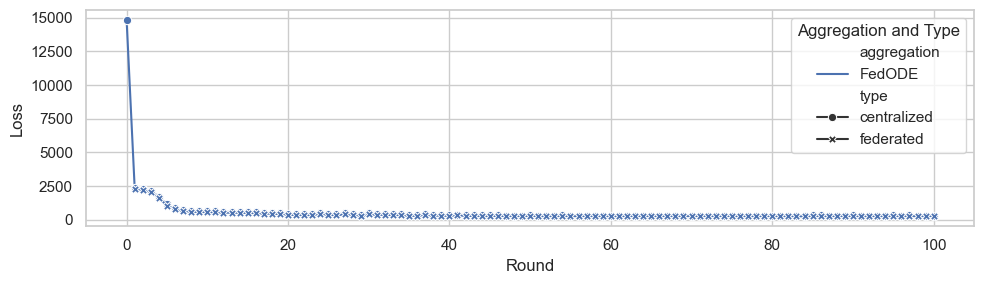

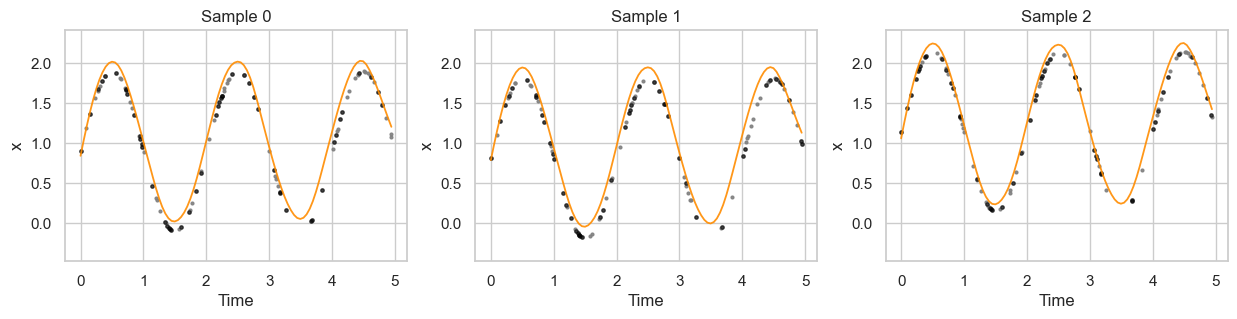

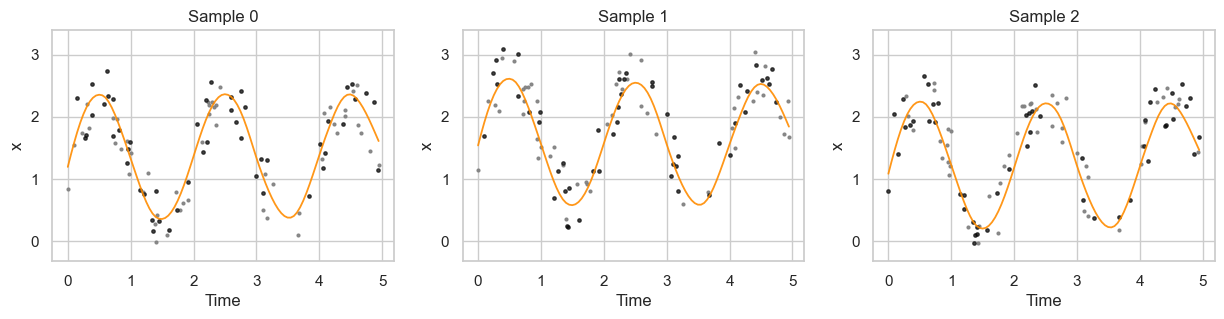

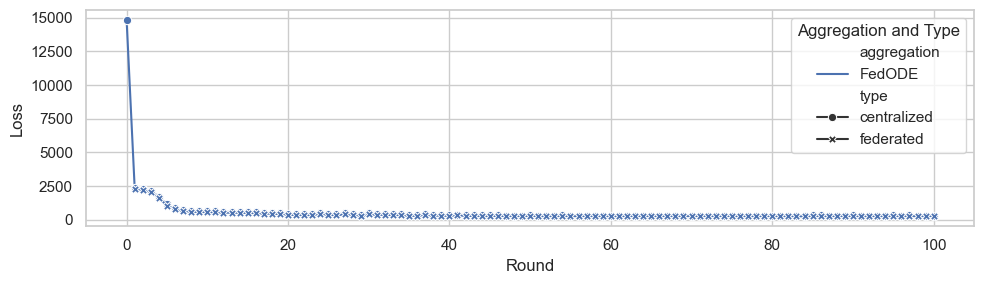

In [186]:
noise = 1.0
alpha = 0.0
data_folder = "../data/"
dataset_prefix = f"noise_one_noise_{noise}"
path_prefix = "/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data"

data_files_0 = glob.glob(os.path.join(data_folder, f"{dataset_prefix}/client_0_test.pt"))[0]
data_files_1 = glob.glob(os.path.join(data_folder, f"{dataset_prefix}/client_1_test.pt"))[0]
timestamps_0 = glob.glob(os.path.join(data_folder, f"{dataset_prefix}/client_0_time_steps_test.pt"))[0]
timestamps_1 = glob.glob(os.path.join(data_folder, f"{dataset_prefix}/client_1_time_steps_test.pt"))[0]
d_0 = torch.load(data_files_0, weights_only=True)
d_1 = torch.load(data_files_1, weights_only=True)
t_0 = torch.load(timestamps_0, weights_only=True)
t_1 = torch.load(timestamps_1, weights_only=True)
w_avg = glob.glob(os.path.join(path_prefix, f"../results_freq_noise/{dataset_prefix}/**/FedAvg/**/model.pth"), recursive=True)[0]
w_ode = glob.glob(os.path.join(path_prefix, f"../results_freq_noise/{dataset_prefix}/**/FedODE/**/model.pth"), recursive=True)[1]

model = Net()
model.load_state_dict(torch.load(w_avg, weights_only=True))
plot_n_outputs(model, d_0, t_0[0], n = 3 )
plot_n_outputs(model, d_1, t_1[0], n = 3 )


# plot loss vs round for the last alpha and type
loss_file = w_0.replace("model.pth", "results.json")
df_cen, df_fed, df_agg = read_loss_file(loss_file)
df = pd.concat([df_cen, df_fed], ignore_index=True)
plt.figure(figsize=(10, 3))
sns.lineplot(data=df, x='round', y='loss', hue='aggregation', style='type', markers=True, dashes=False)
plt.xlabel("Round")
plt.ylabel("Loss")
plt.legend(title='Aggregation and Type')
plt.tight_layout()
plt.show()

model.load_state_dict(torch.load(w_ode, weights_only=True))
plot_n_outputs(model, d_0, t_0[0], n = 3 )
plot_n_outputs(model, d_1, t_1[0], n = 3 )


# plot loss vs round for the last alpha and type
loss_file = w_0.replace("model.pth", "results.json")
df_cen, df_fed, df_agg = read_loss_file(loss_file)
df = pd.concat([df_cen, df_fed], ignore_index=True)
plt.figure(figsize=(10, 3))
sns.lineplot(data=df, x='round', y='loss', hue='aggregation', style='type', markers=True, dashes=False)
plt.xlabel("Round")
plt.ylabel("Loss")
plt.legend(title='Aggregation and Type')
plt.tight_layout()
plt.show()

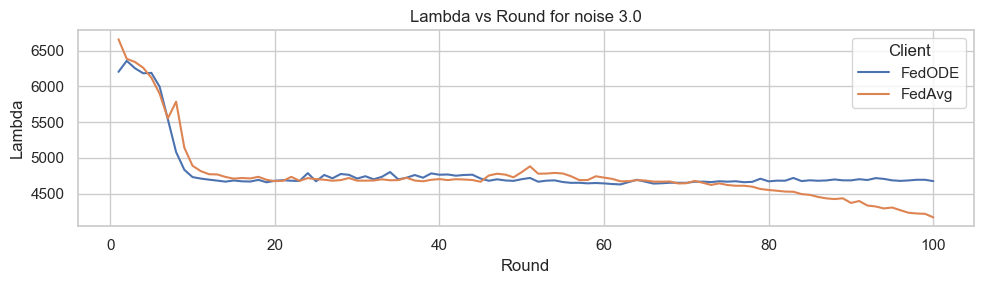

In [160]:
plt.figure(figsize=(10, 3))
df_test = df_summary[(df_summary['noise'] == noise) & (df_summary['alpha'] == alpha)]
df_test = df_test[df_test['type'] == 'federated']

sns.lineplot(data=df_test, x='round', y='loss', hue='aggregation', markers=True)
plt.title(f"Lambda vs Round for noise {noise}")
plt.xlabel("Round")
plt.ylabel("Lambda")
plt.legend(title='Client')
plt.tight_layout()
plt.show()

In [115]:
df_summary_lambdas_last_round = df_summary_lambdas[df_summary_lambdas['round'] == 100].copy()

<Figure size 1000x300 with 0 Axes>

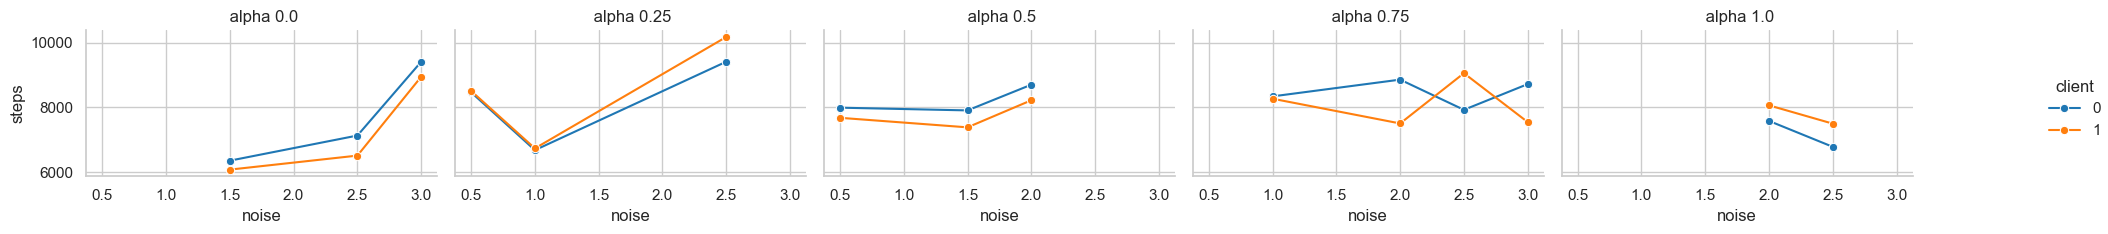

In [171]:

# ensure round is int
plt.figure(figsize=(10, 3))
# Create FacetGrid
g = sns.FacetGrid(
    df_summary_lambdas_last_round,
    col="alpha",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=True
)

# Map the lineplot onto the grid
g.map_dataframe(
    sns.lineplot,
    x='noise',
    y='steps',
    hue="client",
    palette='tab10',
    marker='o'
)

# Adjustments
g.set_titles(" alpha {col_name}")

# Move legend outside
g.add_legend(title ="client")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
plt.tight_layout()
plt.show()

In [53]:
df_summary_aggregation['lambdas']
# get the unique values of lambdas, where lambda is a list, take first element of the list
lambdas = df_summary_aggregation['lambdas'].apply(lambda x: x[0] if isinstance(x, list) else x).unique()
lambdas = sorted(lambdas)
lambdas

[0.4110953651217072,
 0.4351173020527859,
 0.4442958447374969,
 0.45575642245480497,
 0.457086406743941,
 0.45733899967309577,
 0.4603828446813666,
 0.46039699364039316,
 0.46311475409836067,
 0.4635782205116595,
 0.4638398622470943,
 0.4653529316750121,
 0.4657416502946955,
 0.4660565865877263,
 0.4676564014213417,
 0.469406674907293,
 0.4695669470334167,
 0.4697682230433322,
 0.47030218825981246,
 0.47072357981593144,
 0.4713128038897893,
 0.4720157743060822,
 0.4728695652173913,
 0.473928157589803,
 0.47401347449470643,
 0.47413933979736356,
 0.47451456310679613,
 0.47627061595422415,
 0.47635653508160136,
 0.4765971423879126,
 0.4773852385238524,
 0.477578813866409,
 0.47765626903862557,
 0.47787122569971047,
 0.4784290083519586,
 0.4786440677966102,
 0.4786761439360284,
 0.4786921601534404,
 0.4792991161420375,
 0.479498861047836,
 0.47964555835681444,
 0.47975382003395584,
 0.4799877319429535,
 0.48020816259629573,
 0.4804485674025364,
 0.48058458920758385,
 0.48097512765606987,


In [30]:

# explode lambdas 
# lambdas contains a vector 
# take out the 2 lambdas and put them in a new column called lambda and a new column called client and containig 0 or 1\
df_summary['lambda_0'] = df_summary['lambdas'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else np.nan)
df_summary['lambda_1'] = df_summary['lambdas'].apply(lambda x: x[1] if isinstance(x, list) and len(x) > 1 else np.nan)
df0 = df_summary[['round', 'difference', 'lambda_0', 'aggregation', 'alpha']].copy()
df0['client'] = 0
df0 = df0.rename(columns={'lambda_0': 'lambda'})
df1 = df_summary[['round', 'difference', 'lambda_1', 'aggregation', 'alpha']].copy()
df1.rename(columns={'lambda_1': 'lambda'}, inplace=True)
df1['client'] = 1
df_summary_lambdas = pd.concat([df0, df1], ignore_index=True)



KeyError: 'lambdas'

In [ ]:

# ensure round is int
plt.figure(figsize=(10, 3))
# Create FacetGrid
g = sns.FacetGrid(
    df_summary_lambdas,
    col="alpha",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=True
)

# Map the lineplot onto the grid
g.map_dataframe(
    sns.lineplot,
    x='difference',
    y='lambda',
    hue="client",
    palette='tab10'
)

# Adjustments
g.set_titles(" alpha {col_name}")
g.set(ylim=(0, None))

# Move legend outside
g.add_legend(title ="client")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
plt.tight_layout()
plt.show()